# Summary

This notebook allows to run the proposed method on simulate data, both using the discovery and the semi-supervised modes.

In [2]:
import sys
sys.path.append("..")

#GPU configuration
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.main as main
import scripts.cnn_models as cnn_models
import scripts.ga_evaluation as ga_evaluation
from IPython import get_ipython
from tqdm import tqdm

plt.ion()
plt.show()


random_state=0
random.seed( random_state )
np.random.seed(random_state)

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Generate dataset

In [3]:
# # Generate isotropic data with different clusters in each subspace => use HDBSCAN
# n_clusters_per_subpace = [3,6,12] # number of clusters in each embedded subspace
# data, best_subspaces, truths = data_generator.make_data_for_ga(
#                  n_clusters_per_subpace,
#                  cluster_std=[2,2,2],
#                  n_uniform_features=500, # noisy uniform features
#                  n_normal_features=500, # noisy normal features
#                  random_redundant=True,
#                  min_subspace_features=4, # sampled number of features in each target subspace
#                  max_subspace_features=6, 
#                  n_samples=1300, # number of samples in the dataset
#                  plot=True,
#                  isotropic = False)
# truth =None
# n_clusters = int(np.mean(n_clusters_per_subpace))
# nb_top_subspaces = len(n_clusters_per_subpace) + 1 # number of subspaces to return

The cell below creates 3 gaussian clusters having 0.05 cluster standard deviation, accompanied by 300 unrelated samples from each of the following distributions: uniform, normal, negative binomial.

ARI  1.0, std 0.05


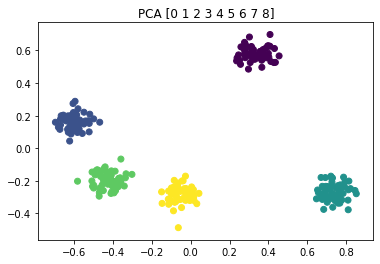

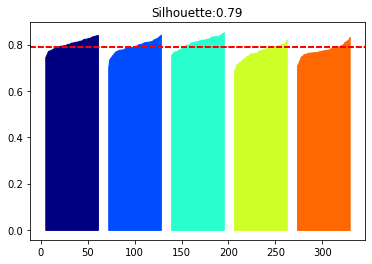

ARI  1.0, std 0.05


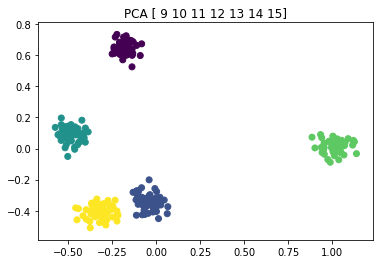

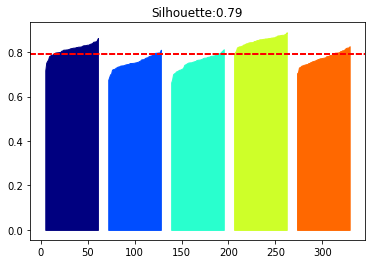

ARI  1.0, std 0.05


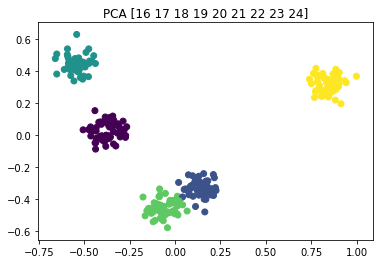

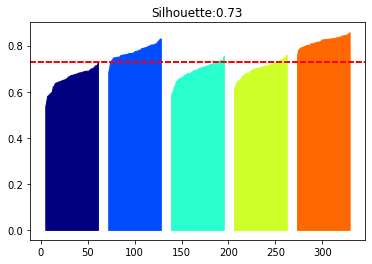

Total: (285, 926), uniform (285, 300) , normal (285, 300),neg bin (285, 300), gamma (285, 0), moon (285, 2), circle (285, 2),  bimodal (285, 0), redundat (285, 1), outliers with uniform (285, 0), outliers with normal (285, 0) ,outlier binomial (285, 0), beta features (285, 0), 


((285, 926),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
  array([ 9, 10, 11, 12, 13, 14, 15]),
  array([16, 17, 18, 19, 20, 21, 22, 23, 24])])

In [5]:
n_clusters_per_subpace = [5,5,5] # number of clusters per embedded subspace
cluster_std=[0.05, 0.05, 0.05] # standard deviation of clusters in each subspace
n_uniform_features=300 # number of noisy uniform features
n_normal_features=300 # number of noisy normal features
n_neg_binomial = 300 # number of noisy negative binomial features
n_clusters = int(np.mean(n_clusters_per_subpace))

data, best_subspaces, truths = data_generator.make_data_for_ga(
                     n_clusters_per_subpace,
                     cluster_std=cluster_std,
                     n_uniform_features=n_uniform_features,
                     n_normal_features=n_normal_features,
                     n_neg_binomial = n_neg_binomial,
                     random_redundant=True,
                     min_subspace_features=4,
                     max_subspace_features=10,
                     max_neg_bin_p = 0.3,
                     n_samples=None,
                     plot=True)
truth = None
imp_f = np.concatenate(best_subspaces)
nb_top_subspaces = len(n_clusters_per_subpace) + 1 # number of subspaces to return
data.shape, imp_f, best_subspaces

# Analyze dataset with 1 method call

We start with the unsupervised analysis which is performed with both HDBSCAN and GMM. We analyze and compare the obtained results.

In [6]:
all_results = {} # collects the results of all runs

In [7]:
method = "adapted_silhouette"
clustering = "hdbscan"
all_results[f"{clustering}_{method}"] = main.discovery_analysis(
    data,
    truth,
    n_clusters,
    nb_top_subspaces=nb_top_subspaces,
    sampling=None,
    allow_subspace_overlap=True,
    redundant_threshold=0.5,
    round_size=3,
    metric='euclidean',
    method=method,
    clustering=clustering,
    max_ranking_2d=None)

*** Unsupervised Analysis
*** Computing 1D feature ranking ...
Dispersion tests took 0.02 sec
Entropy computation 0.3 sec
KNN computation 0.02 sec
Sorting and thresholds 0.03 sec
Performing hierarchical clustering...
Hierarchical clustering 0.09 sec
Handle redundant features 0.0 sec
Returning 0 redundant features and  36 important features
*** Exploring 2D feature space with NN ...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


handle_close_important (29, 3), total 1690, 0.12982553243637085
relevant_features 575 => computing 3415 
trimming 943 to 0
handle_important_features (29, 3),  total 3415, 0.12982553243637085
irrelevant_features 351 => computing 1041
handle_not_important_features (29, 3), total 1041, 0.12982553243637085
handle_all_features 926 => computing 2763


  0%|          | 0/13 [00:00<?, ?it/s]

handle_all_features (337, 3),  total 2763, 0.12982553243637085
Returning (337, 3), explored a total of 8909 feature pairs
*** Optimization algorithm 
Non redundant features 926, orig size 926, nb imp : 36
Selecting (50, 4) from archive


 23%|██▎       | 3/13 [00:07<00:27,  2.74s/it]

,adapted_silhouette,features,partition,size,structure
0,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"


Selecting (9, 4) from archive


 46%|████▌     | 6/13 [00:19<00:21,  3.11s/it]

,adapted_silhouette,features,partition,size,structure
0,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"
1,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"


Selecting (23, 4) from archive


 69%|██████▉   | 9/13 [00:31<00:13,  3.39s/it]

,adapted_silhouette,features,partition,size,structure
0,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"
1,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"
2,0.675625,"[9, 10, 11, 12, 13, 14, 15]","[3, 1, 2, 4, 3, 2, 2, 2, 2, 3, 1, 2, 0, 4, 4, ...",7.0,"Counter({3: 57, 1: 57, 2: 57, 4: 57, 0: 57})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [00:43<00:03,  3.46s/it]

,adapted_silhouette,features,partition,size,structure
0,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"
1,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"
2,0.675625,"[9, 10, 11, 12, 13, 14, 15]","[3, 1, 2, 4, 3, 2, 2, 2, 2, 3, 1, 2, 0, 4, 4, ...",7.0,"Counter({3: 57, 1: 57, 2: 57, 4: 57, 0: 57})"
3,0.676578,"[2, 4, 5, 6, 7, 8]","[2, 0, 2, 1, 3, 3, 4, 0, 3, 4, 1, 1, 4, 1, 1, ...",6.0,"Counter({2: 57, 0: 57, 1: 57, 3: 57, 4: 57})"


100%|██████████| 13/13 [00:50<00:00,  3.86s/it]


In [8]:
method = "adapted_ratkowsky_lance"
clustering = "gmm"
all_results[f"{clustering}_{method}"] = main.discovery_analysis(
    data,
    truth,
    n_clusters,
    nb_top_subspaces=nb_top_subspaces,
    sampling=None,
    allow_subspace_overlap=True,
    redundant_threshold=0.5,
    round_size=3,
    metric='euclidean',
    method=method,
    clustering=clustering,
    max_ranking_2d=None)

*** Unsupervised Analysis
*** Computing 1D feature ranking ...
Dispersion tests took 0.02 sec
Entropy computation 0.3 sec
KNN computation 0.01 sec
Sorting and thresholds 0.01 sec
Performing hierarchical clustering...
Hierarchical clustering 0.07 sec
Handle redundant features 0.0 sec
Returning 0 redundant features and  36 important features
*** Exploring 2D feature space with NN ...
handle_close_important (29, 3), total 1690, 0.12982553243637085
relevant_features 575 => computing 3415 
trimming 943 to 0
handle_important_features (29, 3),  total 3415, 0.12982553243637085
irrelevant_features 351 => computing 1041
handle_not_important_features (29, 3), total 1041, 0.12982553243637085
handle_all_features 926 => computing 2763


  0%|          | 0/13 [00:00<?, ?it/s]

handle_all_features (337, 3),  total 2763, 0.12982553243637085
Returning (337, 3), explored a total of 8909 feature pairs
*** Optimization algorithm 
Non redundant features 926, orig size 926, nb imp : 36
Selecting (50, 4) from archive


 23%|██▎       | 3/13 [00:11<00:37,  3.80s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"


Selecting (17, 4) from archive


 46%|████▌     | 6/13 [00:30<00:34,  4.95s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"


Selecting (38, 4) from archive


 69%|██████▉   | 9/13 [00:53<00:23,  5.95s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"
2,0.167784,"[9, 10, 11, 12, 13, 14, 15]","[2, 0, 3, 4, 2, 3, 3, 3, 3, 2, 0, 3, 1, 4, 4, ...",7.0,"Counter({2: 57, 0: 57, 3: 57, 4: 57, 1: 57})"


Selecting (25, 4) from archive


 92%|█████████▏| 12/13 [01:17<00:06,  6.65s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"
2,0.167784,"[9, 10, 11, 12, 13, 14, 15]","[2, 0, 3, 4, 2, 3, 3, 3, 3, 2, 0, 3, 1, 4, 4, ...",7.0,"Counter({2: 57, 0: 57, 3: 57, 4: 57, 1: 57})"
3,0.170070,"[0, 2, 3, 4, 5, 6, 7, 8]","[2, 3, 2, 0, 1, 1, 4, 3, 1, 4, 0, 0, 4, 0, 0, ...",8.0,"Counter({2: 57, 3: 57, 0: 57, 1: 57, 4: 57})"


100%|██████████| 13/13 [01:31<00:00,  7.03s/it]


# Evaluate results

In [9]:
eval_df = ga_evaluation.evaluate_ga_result(all_results, best_subspaces, truths)
eval_df.groupby("experiment").agg({"identified_features": "mean", "ari": "mean"})

,identified_features,ari
experiment,,
gmm_adapted_ratkowsky_lance,1.000000,1.0
hdbscan_adapted_silhouette,0.962963,1.0


# Semi-supervised approach
Select a pair of features from one target subspace and perform the maximization analysis

In [10]:
seed =  np.random.choice(best_subspaces[0], 2, replace = False)
seed

array([8, 3])

In [11]:
result = main.semi_supervised_analysis([seed],
                                       data,
                                       truth,
                                       n_clusters,
                                       sampling=None,
                                       debug=False,
                                       allow_subspace_overlap=True,
                                       redundant_threshold=0.5,
                                       metric='euclidean',
                                       method="adapted_ratkowsky_lance",
                                       model_file=f'../models/gmm_arl.h5',
                                       clustering="gmm")
subspace = result["features"].values[0]

*** Semi Supervised Analysis
*** Computing 1D feature ranking ...
Dispersion tests took 0.02 sec
Entropy computation 0.3 sec
KNN computation 0.02 sec
Sorting and thresholds 0.02 sec
Performing hierarchical clustering...
Hierarchical clustering 0.09 sec
Handle redundant features 0.0 sec
Returning 0 redundant features and  36 important features
*** Exploring 2D feature space with NN ...
handle_close_important (29, 3), total 1690, 0.12982553243637085
relevant_features 575 => computing 3415 
trimming 943 to 0
handle_important_features (29, 3),  total 3415, 0.12982553243637085
irrelevant_features 351 => computing 1041
handle_not_important_features (29, 3), total 1041, 0.12982553243637085
handle_all_features 926 => computing 2763
handle_all_features (337, 3),  total 2763, 0.12982553243637085
Returning (337, 3), explored a total of 8909 feature pairs
*** Optimization algorithm 
Non redundant features 926, orig size 926, nb imp : 36
Initial subspace score {'adapted_ratkowsky_lance': 0.12711437

In [13]:
clustering = "gmm"
main.evaluate_subspace(subspace,
                       data,
                       clustering,
                       n_clusters,
                       truths[0],
                       methods=["adapted_ratkowsky_lance", "silhouette"])

({'adapted_ratkowsky_lance': 0.1704081481026865,
  'silhouette': 0.7796691273779783,
  'ari': 1.0,
  'structure': 'Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})'},
 array([4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, 1, 4, 0, 1, 3, 1, 1,
        2, 3, 1, 3, 2, 2, 1, 1, 4, 3, 1, 2, 2, 4, 1, 3, 4, 2, 1, 2, 4, 2,
        2, 2, 2, 4, 2, 3, 4, 3, 4, 4, 3, 3, 1, 0, 0, 0, 3, 4, 1, 0, 1, 4,
        3, 1, 4, 1, 4, 4, 1, 0, 4, 2, 1, 0, 0, 4, 4, 2, 1, 4, 0, 3, 1, 1,
        3, 0, 2, 1, 3, 4, 0, 4, 3, 0, 1, 4, 1, 0, 2, 1, 1, 4, 2, 3, 2, 2,
        4, 3, 0, 2, 3, 0, 3, 4, 0, 0, 4, 0, 3, 3, 3, 3, 2, 1, 1, 4, 2, 3,
        1, 4, 2, 2, 0, 0, 2, 0, 1, 2, 4, 4, 0, 1, 3, 1, 3, 1, 4, 4, 3, 3,
        0, 4, 2, 2, 1, 4, 3, 4, 3, 3, 0, 3, 1, 2, 2, 4, 4, 1, 0, 2, 2, 0,
        0, 2, 3, 0, 3, 0, 4, 1, 4, 0, 2, 4, 2, 0, 3, 4, 4, 2, 3, 4, 0, 2,
        0, 1, 4, 4, 2, 3, 3, 2, 3, 2, 3, 0, 1, 3, 1, 1, 1, 1, 2, 4, 0, 1,
        1, 0, 2, 3, 0, 4, 3, 0, 0, 2, 3, 0, 2, 1, 3, 0, 0, 0, 4, 4, 1, 2,
        0, 0, 2, 1, 2, 

# Step by step approach

In [14]:
meta_features = feature_ranking.rank_features(data,
                                              nb_bins=20,
                                              rank_threshold=90,
                                              z_file=None,
                                              metric='euclidean',
                                              redundant_threshold=0.4)

*** Computing 1D feature ranking ...
Dispersion tests took 0.02 sec
Entropy computation 0.3 sec
KNN computation 0.02 sec
Sorting and thresholds 0.02 sec
Performing hierarchical clustering...
Hierarchical clustering 0.07 sec
Handle redundant features 0.0 sec
Returning 0 redundant features and  28 important features


In [15]:
model_file = "../models/gmm_arl.h5"
n_clusters = 5
population, n = features_2d.run(data, n_clusters,
                       meta_features,
                       model_file=model_file,
                       add_close_population=False)
population.shape

*** Exploring 2D feature space with NN ...
handle_close_important (28, 3), total 1446, 0.12982553243637085
relevant_features 492 => computing 2913 
trimming 1042 to 0
handle_important_features (28, 3),  total 2913, 0.12982553243637085
irrelevant_features 434 => computing 1294
handle_not_important_features (28, 3), total 1294, 0.12982553243637085
handle_all_features 926 => computing 2763
handle_all_features (336, 3),  total 2763, 0.12982553243637085
Returning (336, 3), explored a total of 8416 feature pairs


(336, 4)

In [16]:
round_size = 4
debug = False
ignore_redundant= True
epochs = 5*round_size
globalResults = {}

In [17]:
clustering = "hdbscan"
method = "adapted_silhouette"
threshold=0.1
score_tolerance=0.01

truth = None

sampling = {
    "ARCHIVE2D": { 
        "ga": 0.5,
        "max": 0.5 },
    "CLOSE": { 
        "ga": 0.25,
        "max": 0.25 },
    "IMP1D": { 
        "ga": 0.15,
        "max": 0.15 },
    "RANDOM": { 
        "ga": 0.1,
        "max": 0.1},
}
params = ga.ga_parameters(
    n_clusters,
    data.shape[1],
    truth,
    meta_features,
    method=method,
    truth_methods=['ari'],
    archive_2d=population[population["pred"] > threshold],
    debug=debug,
    epochs=epochs,
    round_size=round_size,
    sampling = sampling,
    ignore_redundant = ignore_redundant,
    allow_subspace_overlap = False,
    improvement_per_mutation_report = True,
    score_tolerance=score_tolerance,
    clustering = clustering,
    total_maximisation_exploration = 150

)
print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])
params

solutions, archive= ga.run(data, params)
display(solutions)
globalResults[f"{clustering}_{method}"] = solutions

  0%|          | 0/21 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 926, orig size 926, nb imp : 28
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [50 25 15 10] [0.5, 0.25, 0.15, 0.1]
Selecting (50, 4) from archive


 19%|█▉        | 4/21 [00:12<00:53,  3.15s/it]

,adapted_silhouette,features,partition,size,structure
0,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"


Selecting (25, 4) from archive


 38%|███▊      | 8/21 [00:28<00:44,  3.40s/it]

,adapted_silhouette,features,partition,size,structure
0,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"
1,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"


Selecting (10, 4) from archive


 57%|█████▋    | 12/21 [00:44<00:31,  3.52s/it]

,adapted_silhouette,features,partition,size,structure
0,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"
1,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"
2,0.675625,"[9, 10, 11, 12, 13, 14, 15]","[3, 1, 2, 4, 3, 2, 2, 2, 2, 3, 1, 2, 0, 4, 4, ...",7.0,"Counter({3: 57, 1: 57, 2: 57, 4: 57, 0: 57})"


Selecting (50, 4) from archive


 76%|███████▌  | 16/21 [00:58<00:16,  3.31s/it]

,adapted_silhouette,features,partition,size,structure
0,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"
1,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"
2,0.675625,"[9, 10, 11, 12, 13, 14, 15]","[3, 1, 2, 4, 3, 2, 2, 2, 2, 3, 1, 2, 0, 4, 4, ...",7.0,"Counter({3: 57, 1: 57, 2: 57, 4: 57, 0: 57})"
3,0.166950,"[186, 801]","[-1, -1, 1, -1, -1, 0, 1, 1, 1, 1, -1, 1, 0, 1...",2.0,"Counter({-1: 120, 1: 93, 0: 72})"


Selecting (7, 4) from archive


 95%|█████████▌| 20/21 [01:13<00:03,  3.22s/it]

,adapted_silhouette,features,partition,size,structure
0,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"
1,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"
2,0.675625,"[9, 10, 11, 12, 13, 14, 15]","[3, 1, 2, 4, 3, 2, 2, 2, 2, 3, 1, 2, 0, 4, 4, ...",7.0,"Counter({3: 57, 1: 57, 2: 57, 4: 57, 0: 57})"
3,0.166950,"[186, 801]","[-1, -1, 1, -1, -1, 0, 1, 1, 1, 1, -1, 1, 0, 1...",2.0,"Counter({-1: 120, 1: 93, 0: 72})"
4,0.172119,"[94, 773]","[0, -1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,...",2.0,"Counter({1: 103, -1: 92, 0: 90})"


Selecting (3, 4) from archive


100%|██████████| 21/21 [01:18<00:00,  3.74s/it]


,adapted_silhouette,features,partition,size,structure
0,0.701702,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 0, 3, 4, 2, 2, 1, 0, 2, 1, 4, 4, 1, 4, 4, ...",9.0,"Counter({3: 57, 0: 57, 4: 57, 2: 57, 1: 57})"
1,0.649431,"[16, 17, 18, 19, 20, 21, 22, 23]","[3, 1, 2, 1, 3, 2, 0, 1, 2, 0, 4, 2, 3, 3, 2, ...",8.0,"Counter({3: 57, 1: 57, 2: 57, 0: 57, 4: 57})"
2,0.675625,"[9, 10, 11, 12, 13, 14, 15]","[3, 1, 2, 4, 3, 2, 2, 2, 2, 3, 1, 2, 0, 4, 4, ...",7.0,"Counter({3: 57, 1: 57, 2: 57, 4: 57, 0: 57})"
3,0.166950,"[186, 801]","[-1, -1, 1, -1, -1, 0, 1, 1, 1, 1, -1, 1, 0, 1...",2.0,"Counter({-1: 120, 1: 93, 0: 72})"
4,0.172119,"[94, 773]","[0, -1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,...",2.0,"Counter({1: 103, -1: 92, 0: 90})"


In [18]:
clustering = "gmm"
method = "adapted_ratkowsky_lance"
threshold=0.09
score_tolerance=0.009

truth = None

sampling = {
    "ARCHIVE2D": { 
        "ga": 0.5,
        "max": 0.5 },
    "CLOSE": { 
        "ga": 0.25,
        "max": 0.25 },
    "IMP1D": { 
        "ga": 0.15,
        "max": 0.15 },
    "RANDOM": { 
        "ga": 0.1,
        "max": 0.1},
}
params = ga.ga_parameters(
    n_clusters,
    data.shape[1],
    truth,
    meta_features,
    method=method,
    truth_methods=['ari'],
    archive_2d=population[population["pred"] > threshold],
    debug=debug,
    epochs=epochs,
    round_size=round_size,
    sampling = sampling,
    ignore_redundant = ignore_redundant,
    allow_subspace_overlap = False,
    improvement_per_mutation_report = True,
    score_tolerance=score_tolerance,
    clustering = clustering,
    total_maximisation_exploration = 150

)
print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])
params

solutions, archive= ga.run(data, params)
display(solutions)
globalResults[f"{clustering}_{method}"] = solutions

  0%|          | 0/21 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 926, orig size 926, nb imp : 28
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [50 25 15 10] [0.5, 0.25, 0.15, 0.1]
Selecting (50, 4) from archive


 19%|█▉        | 4/21 [00:15<01:05,  3.84s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"


Selecting (14, 4) from archive


 38%|███▊      | 8/21 [00:40<01:05,  5.01s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"


Selecting (26, 4) from archive


 57%|█████▋    | 12/21 [01:03<00:45,  5.04s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"
2,0.167784,"[9, 10, 11, 12, 13, 14, 15]","[2, 0, 3, 4, 2, 3, 3, 3, 3, 2, 0, 3, 1, 4, 4, ...",7.0,"Counter({2: 57, 0: 57, 3: 57, 4: 57, 1: 57})"


Selecting (35, 4) from archive


 76%|███████▌  | 16/21 [01:27<00:25,  5.16s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"
2,0.167784,"[9, 10, 11, 12, 13, 14, 15]","[2, 0, 3, 4, 2, 3, 3, 3, 3, 2, 0, 3, 1, 4, 4, ...",7.0,"Counter({2: 57, 0: 57, 3: 57, 4: 57, 1: 57})"
3,0.117444,"[28, 59, 925]","[4, 4, 4, 2, 0, 0, 0, 2, 1, 1, 3, 0, 3, 2, 1, ...",3.0,"Counter({2: 64, 3: 62, 0: 61, 4: 56, 1: 42})"


Selecting (2, 4) from archive


 95%|█████████▌| 20/21 [01:49<00:04,  4.83s/it]

,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"
2,0.167784,"[9, 10, 11, 12, 13, 14, 15]","[2, 0, 3, 4, 2, 3, 3, 3, 3, 2, 0, 3, 1, 4, 4, ...",7.0,"Counter({2: 57, 0: 57, 3: 57, 4: 57, 1: 57})"
3,0.117444,"[28, 59, 925]","[4, 4, 4, 2, 0, 0, 0, 2, 1, 1, 3, 0, 3, 2, 1, ...",3.0,"Counter({2: 64, 3: 62, 0: 61, 4: 56, 1: 42})"
4,0.104355,"[69, 267, 699]","[2, 4, 0, 2, 1, 1, 3, 2, 3, 4, 4, 2, 2, 4, 0, ...",3.0,"Counter({0: 70, 2: 69, 1: 68, 4: 59, 3: 19})"


Selecting (3, 4) from archive


100%|██████████| 21/21 [01:58<00:00,  5.63s/it]


,adapted_ratkowsky_lance,features,partition,size,structure
0,0.169025,"[16, 17, 18, 19, 20, 21, 22, 23, 24]","[0, 2, 3, 2, 0, 3, 1, 2, 3, 1, 4, 3, 0, 0, 3, ...",9.0,"Counter({0: 57, 2: 57, 3: 57, 1: 57, 4: 57})"
1,0.170408,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4, 3, 4, 0, 1, 1, 2, 3, 1, 2, 0, 0, 2, 0, 0, ...",9.0,"Counter({4: 57, 3: 57, 0: 57, 1: 57, 2: 57})"
2,0.167784,"[9, 10, 11, 12, 13, 14, 15]","[2, 0, 3, 4, 2, 3, 3, 3, 3, 2, 0, 3, 1, 4, 4, ...",7.0,"Counter({2: 57, 0: 57, 3: 57, 4: 57, 1: 57})"
3,0.117444,"[28, 59, 925]","[4, 4, 4, 2, 0, 0, 0, 2, 1, 1, 3, 0, 3, 2, 1, ...",3.0,"Counter({2: 64, 3: 62, 0: 61, 4: 56, 1: 42})"
4,0.104355,"[69, 267, 699]","[2, 4, 0, 2, 1, 1, 3, 2, 3, 4, 4, 2, 2, 4, 0, ...",3.0,"Counter({0: 70, 2: 69, 1: 68, 4: 59, 3: 19})"


In [19]:
eval_df = ga_evaluation.evaluate_ga_result(globalResults, best_subspaces, truths)
eval_df.groupby("experiment").agg({"identified_features": "mean", "ari": "mean"})

,identified_features,ari
experiment,,
gmm_adapted_ratkowsky_lance,1.000000,1.0
hdbscan_adapted_silhouette,0.962963,1.0
